In [ ]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib
# reload modules & set fname
importlib.reload(icrms)
importlib.reload(lcmsfns)


dir='/Volumes/Samsung_T5/NHMFL/clustering/pos/spring'
flist=os.listdir(dir)
os.chdir(dir)

fname = 'spring_CHONFe.csv'


In [ ]:
# get files & parsers

MSfiles={}

for f in flist:
    if ('.raw' in f) & ('._' not in f):
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}

data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

data._raw_filelist = data.master_data_holder.keys()

In [ ]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['Fe'] = (0,1)
#MSParameters.molecular_search.usedAtoms['S'] = (0,1)
#MSParameters.molecular_search.usedAtoms['P'] = (0,1)




In [ ]:
# run assignment algorithm
timerange = [4,24]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist, calorder =2)

data_df = data.complete_results_df

In [ ]:
# save assignment results as pd dataframe and export as .csv 

data_df.to_csv(dir+'/' +fname)


In [95]:
#-#-#-# read assignment results from .csv
data_df = pd.read_csv(dir+'/'+fname) 

In [113]:
# add 'm/z window' and 'rep' columns

importlib.reload(icrms)
importlib.reload(lcmsfns)

data_df = pd.read_csv(dir+'/' +fname)
data_df = lcmsfns.add_mzwindow_col(data_df)

data_df = lcmsfns.addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())
print(data_df['Window Size (m/z)'].unique())

20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw
[1 2]
['200-1200 m/z' '500-600 m/z' '400-600 m/z' '400-500 m/z']
[1 2]
['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_

In [114]:
backup = data_df

In [240]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
data_df = backup

In [241]:
# add mol classes
importlib.reload(icrms)
importlib.reload(lcmsfns)

heter = ['N', 'Fe']
molclasses = lcmsfns.get_mol_class(heter)

data_df = lcmsfns.assign_mol_class(data_df,molclasses)



time: 4
unassigned:  5016
assigned:  4234
	CHO: 1577
	CHON: 2567
	CHONFe: 87
	CHOFe: 3
	Unassigned: 5016

time: 6
unassigned:  6387
assigned:  8270
	CHO: 2682
	CHON: 5454
	CHONFe: 132
	CHOFe: 2
	Unassigned: 6387

time: 8
unassigned:  7396
assigned:  10896
	CHO: 3589
	CHON: 7110
	CHONFe: 190
	CHOFe: 7
	Unassigned: 7396

time: 10
unassigned:  7220
assigned:  12663
	CHO: 4491
	CHON: 8003
	CHONFe: 164
	CHOFe: 5
	Unassigned: 7220

time: 12
unassigned:  8089
assigned:  14068
	CHO: 5301
	CHON: 8568
	CHONFe: 197
	CHOFe: 2
	Unassigned: 8089

time: 14
unassigned:  8143
assigned:  15479
	CHO: 6166
	CHON: 9157
	CHONFe: 153
	CHOFe: 3
	Unassigned: 8143

time: 16
unassigned:  7959
assigned:  15857
	CHO: 6686
	CHON: 9035
	CHONFe: 131
	CHOFe: 5
	Unassigned: 7959

time: 18
unassigned:  7813
assigned:  16505
	CHO: 7326
	CHON: 9020
	CHONFe: 154
	CHOFe: 5
	Unassigned: 7813

time: 20
unassigned:  7591
assigned:  17411
	CHO: 7960
	CHON: 9294
	CHONFe: 153
	CHOFe: 4
	Unassigned: 7591

time: 22
unassigned:  58

In [242]:
# create 200 m/z blank files from 100 m/z blank files and add column with blank file identity 

blank_files = [f for f in data._raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    if 'fullmz' not in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_df = pd.concat(blank_data)

rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
rep1_temp = rep1_temp[rep1_temp['m/z'] <= 600]
rep1_temp['file'] = 'mz200_400_600_blnk'
rep1_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])

rep2_temp = blanks_df[blanks_df['file'].str.contains('rep2')]
rep2_temp = rep2_temp[rep2_temp['m/z'] <= 600]
rep2_temp['file'] = 'mz200_400_600_blnk_rep2'
rep2_temp['m/z window'] = '400-600 m/z'


blanks_df = pd.concat([blanks_df,rep2_temp])

print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())

mz200_blanks = blanks_df[blanks_df['m/z window'] == '400-600 m/z']
mz200_blanks['Window Size (m/z)'] = '200'

n200bs = len(mz200_blanks)
max_index = max(data_df.index)
compatible_index = range(max_index, max_index+n200bs,1)
mz200_blanks.index = compatible_index

data_df = pd.concat([data_df, mz200_blanks])

blank_data = []

for f in blank_files:

    if 'fullmz' in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_fullmz_df = pd.concat(blank_data)
temp = blanks_df
blanks_df = pd.concat([blanks_df,blanks_fullmz_df])

df_bs = []
for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window
    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]

        temp2['blank file'] = btemp2['file'].iloc[0]
        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2

        df_bs.append(temp2)

df_bs = pd.concat(df_bs)

data_df =df_bs

['20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw'
 'mz200_400_600_blnk' 'mz200_400_600_blnk_rep2']
['500-600 m/z' '400-500 m/z' '400-600 m/z']


In [ ]:
# add column with blank file identity to use in blank subtraction -- do not use if creating blank for 200 m/z window with 100 m/z window blank data 

raw_filelist = data_df['file'].unique()

blank_files = [f for f in raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    #if 'fullmz' not in f:
        
    temp = data_df[data_df['file'] == f] 

    blank_data.append(temp)

blanks_df = pd.concat(blank_data)  # these are only 100 m/z blanks (200 m/z blanks were not collected)


print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())


data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window
    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]

     #  print(np.shape( btemp2['file']))

        temp2['blank file'] = btemp2['file'].iloc[0]
     #   print(np.shape( btemp2['file']))
        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2




In [ ]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv(dir+'/blank_subtracted_'+fname)


In [ ]:
#-#-#-# read assignment results from .csv
data_df = pd.read_csv(dir+'/processed_'+fname) 

In [243]:
# create subsets of assignments based m/z window

list100mz = []
list200mz = []
listfullzmz = [] 

"""for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '400-600 m/z') or (mzwindow == '300-500 m/z'):
        list200mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) """

for mzwindow in data_df['Window Size (m/z)'].unique():

    r_df = data_df[data_df['Window Size (m/z)'] == mzwindow]

    if (mzwindow == "100"):
        list100mz.append(r_df) 

    elif (mzwindow == "200"):
        list200mz.append(r_df) 

    elif (mzwindow == "1000"):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz,ignore_index=True)
mz200 = pd.concat(list200mz,ignore_index=True)
mzfull = pd.concat(listfullzmz,ignore_index=True)


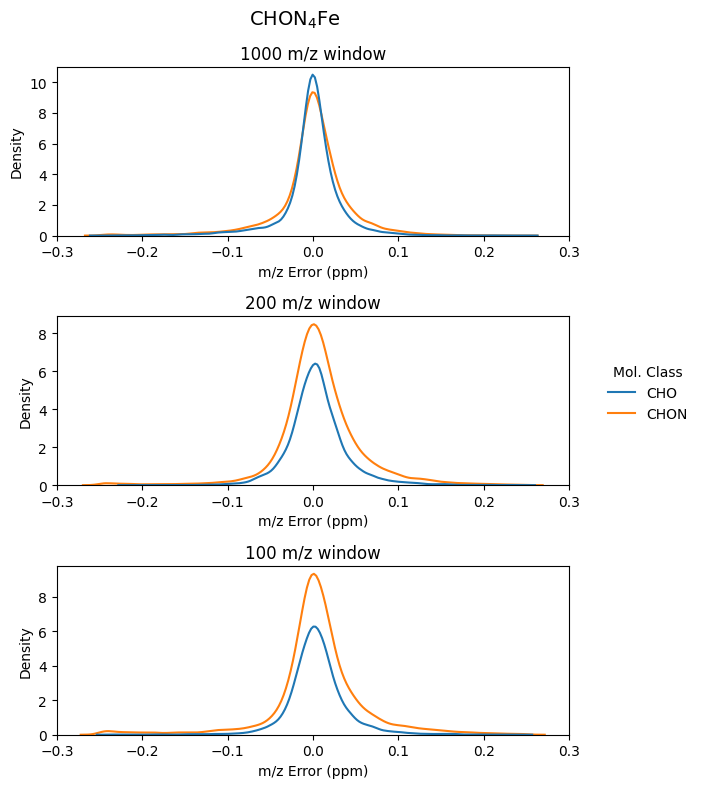

In [32]:
# plot assignment error kernel density CHON

ttt = 'CHON$_4$Fe'  ## title for main plot

dffull = mzfull[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
df200 = mz200[(mz200['mol_class']=='CHO') | (mz200['mol_class']=='CHON')]
df100 = mz100[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]


fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize = (6,8))


sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( '1000 m/z window')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()


sns.kdeplot(data=df200[df200['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False)
ax2.set_title( '200 m/z window')
ax2.set_xlim(-0.3,0.3)


sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax3, legend = False)
ax3.set_title( '100 m/z window')
ax3.set_xlim(-0.3,0.3)



fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [ ]:
# plot assignment error kernel density CHON
import itertools
ttt = 'CHON$_4$Fe'

# set palette 
palette = itertools.cycle(sns.color_palette())

dffull = mzfull[(mzfull['mol_class']!='CHO') & (mzfull['mol_class']!='CHON')]
df200 = mz200[(mz100['mol_class']!='CHO') & (mz200['mol_class']!='CHON')]
df100 = mz100[(mz100['mol_class']!='CHO') & (mz200['mol_class']!='CHON')]

fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize = (6,8))


sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( '1000 m/z window')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()


sns.kdeplot(data=df200[df200['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False)
ax2.set_title( '200 m/z window')
ax2.set_xlim(-0.3,0.3)


sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax3, legend = False)
ax3.set_title( '100 m/z window')
ax3.set_xlim(-0.3,0.3)



fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [244]:
# create subsets of assigned features and unique features 

importlib.reload(icrms)
importlib.reload(lcmsfns)


assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

unique_100mz = lcmsfns.getUniqueFeatures(assigned_100mz)
unique_200mz = lcmsfns.getUniqueFeatures(assigned_200mz)
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)


print('100 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], (np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100), np.shape(unique_100mz)[0]))
print('\n200 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mz200)[0],  np.shape(assigned_200mz)[0], (np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100), np.shape(unique_200mz)[0]))
print('\n200-1200 m/z window (full scan): \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  (np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100),np.shape(unique_fullmz)[0]))

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

print('400-600 m/z, 200-1200 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100, len(unique_fullmz_456)))



100 m/z window: 
63133 features total; 38251 assigned (60.6%); 22656 unique

200 m/z window: 
67494 features total; 42539 assigned (63.0%); 21481 unique

200-1200 m/z window (full scan): 
83080 features total; 55187 assigned (66.4%); 28790 unique
400-600 m/z, 200-1200 m/z window: 
41128 features total; 26121 assigned (63.5%); 13780 unique


In [260]:
# get combo unique 
import matplotlib.gridspec as gridspec

combo = pd.concat([assigned_100mz, assigned_200mz, assigned_fullmz_456], ignore_index=True)
combo_unique = lcmsfns.getUniqueFeatures(combo)
print(np.shape(combo_unique), np.shape(combo))

(23715, 58) (106911, 38)


In [259]:
# get subsets of data for mz window comparison
# combo with blank subtraction

combo = pd.concat([lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6), 
    lcmsfns.blankSubtract(unique_200mz, blnkthresh = 0.6), 
    lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)], ignore_index=True)

combotest = pd.concat([unique_fullmz_456, 
    unique_200mz, 
    unique_100mz], ignore_index=False)

'''for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'): # or (w == '600-700 m/z'):
        
        combo['Window Size (m/z)'].iloc[i] = '100'
    
    elif (w == '400-600 m/z') :
        
        combo['Window Size (m/z)'].iloc[i] = '200'

    elif (w == '200-1200 m/z'):
        
        combo['Window Size (m/z)'].iloc[i] = '1000'
'''
print(combo['Window Size (m/z)'].unique())


# combo without blank subtraction
mzfull_456 = mzfull[(mzfull['Calibrated m/z']>=400) & (mzfull['Calibrated m/z']<=600)]
combo2 = pd.concat([mz100, mz200, mzfull_456], ignore_index=True)

'''for i in range(len(combo['m/z window'])):

    w = combo2['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'): # or (w == '600-700 m/z'):
        
        combo2['Window Size (m/z)'].iloc[i] = '100'
    
    elif (w == '400-600 m/z') :
        
        combo2['Window Size (m/z)'].iloc[i] = '200'

    elif (w == '200-1200 m/z'):
        
        combo2['Window Size (m/z)'].iloc[i] = '1000'''

print(np.shape(combo),np.shape(combo2))



['1000' '200' '100']
(52034, 59) (171755, 38)


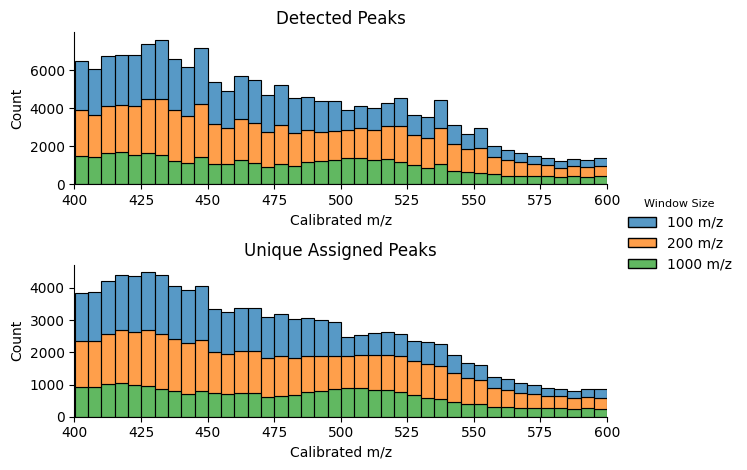

In [261]:
# plot histograms of detected and assigned features, both windows

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])


ax1 = plt.subplot(gs2[0])

sns.histplot(combo, x="Calibrated m/z", hue="Window Size (m/z)", multiple="stack", ax=ax1,binwidth=5)
ax1.set_ylabel('Count')
ax1.legend_.remove()
ax1.set_xlim(400,600)
ax1.set_title('Unique Assigned Peaks')
#ax1.set_ylim(0,4500)

sns.despine(ax=ax1)


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="Window Size (m/z)", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Count')
ax2.set_xlim(400,600)
#ax2.set_ylim(0,4500)
ax2.set_title('Detected Peaks')
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','200 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

fig.tight_layout()
plt.show()

In [ ]:
# plot number of assigned and unassigned features for each 2-min along chroma for both mz windows

fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=600)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=600)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in all_results['mol_class'].unique():
            if mol_class == 'Unassigned':
                current['Unassigned']=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
            else:
                current['Assigned']=len(all_results[(all_results['mol_class']!='Unassigned') & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)

df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)

# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 300-500 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')

colors = ['#EA5739','#FEFFBE','#4BB05C']

#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')

plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.

sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
sns.despine(ax=ax4)

plt.show()





In [ ]:
# plot assignments across separation
# 
fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=600)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=600)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHON', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')
ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, title='Mol. Class')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)

ax4.set_title('Assignments across Separation, 400-600 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.

sns.despine(ax=ax4)
fig = plt.gcf()
fig.tight_layout(pad = 1.)
plt.show()


ValueError: Could not interpret value `m/z Window Size` for parameter `hue`

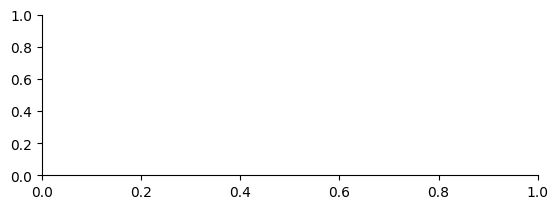

In [195]:
# histogram of features (a) and chromatogram of features (b)
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])

plt.rcParams['legend.title_fontsize'] = 8


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Number of Peaks x $10^3$')
ax2.set_xlim(400,600)
#ax2.set_ylim(0,4500)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.set_title('Detected Peaks, 400-600 m/z', fontsize = 10)
#ax2.legend_.remove()

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
fig = plt.gcf()

ax2.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})
ax2.text(-0.15, 1.05,'a',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax2.transAxes, fontweight='bold', fontsize = 10)

ax4 = plt.subplot(gs2[0])


all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=700)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=700)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHON', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']
ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Number of Peaks x $10^3$')

ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, title='Mol. Class')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 400-600 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.
sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
fig = plt.gcf()
fig.tight_layout(pad = 1.)

plt.show()

In [252]:
# display sets of mfs 

dd = combo_unique

fullscan =  dd[dd['Window Size (m/z)'] == '1000']
midscan = dd[dd['Window Size (m/z)'] == '200']
narrowscan = dd[dd['Window Size (m/z)'] == '100']


narrow_only = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
mid_only = dd[(dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
full_only = dd[(dd['Molecular Formula'].isin(fullscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(midscan['Molecular Formula']))]

narrow_full = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
narrow_mid = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
mid_full = dd[~(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]

features_in_all = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
features_not_in_full = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]

narrow_only['FeatureIn'] = '100'
mid_only['FeatureIn'] = '200'
full_only['FeatureIn'] ='1000'

narrow_full['FeatureIn'] = '100,1000'
narrow_mid['FeatureIn'] = '100,200'
mid_full['FeatureIn'] = '200,1000'

features_in_all['FeatureIn'] = '100,200,1000'

print('MFs in narrow window only: %s' %len(narrow_only))
print('MFs in mid window only: %s' %len(mid_only))
print('MFs in full window only: %s' %len(full_only))
print('MFs in narrow and full window only: %s' %len(narrow_full))
print('MFs in narrow and mid window only: %s' %len(narrow_mid))
print('MFs in mid and full window only: %s' %len(mid_full))
print('MFs in all: %s' %len(features_in_all))
print('MFs not in full: %s' %len(features_not_in_full))



MFs in narrow window only: 1919
MFs in mid window only: 1397
MFs in full window only: 350
MFs in narrow and full window only: 1456
MFs in narrow and mid window only: 6737
MFs in mid and full window only: 2102
MFs in all: 9754
MFs not in full: 6737


5
19647
[1 1 1 ... 1 3 1]
['100 m/z window' '200 m/z window' '1000 m/z window']


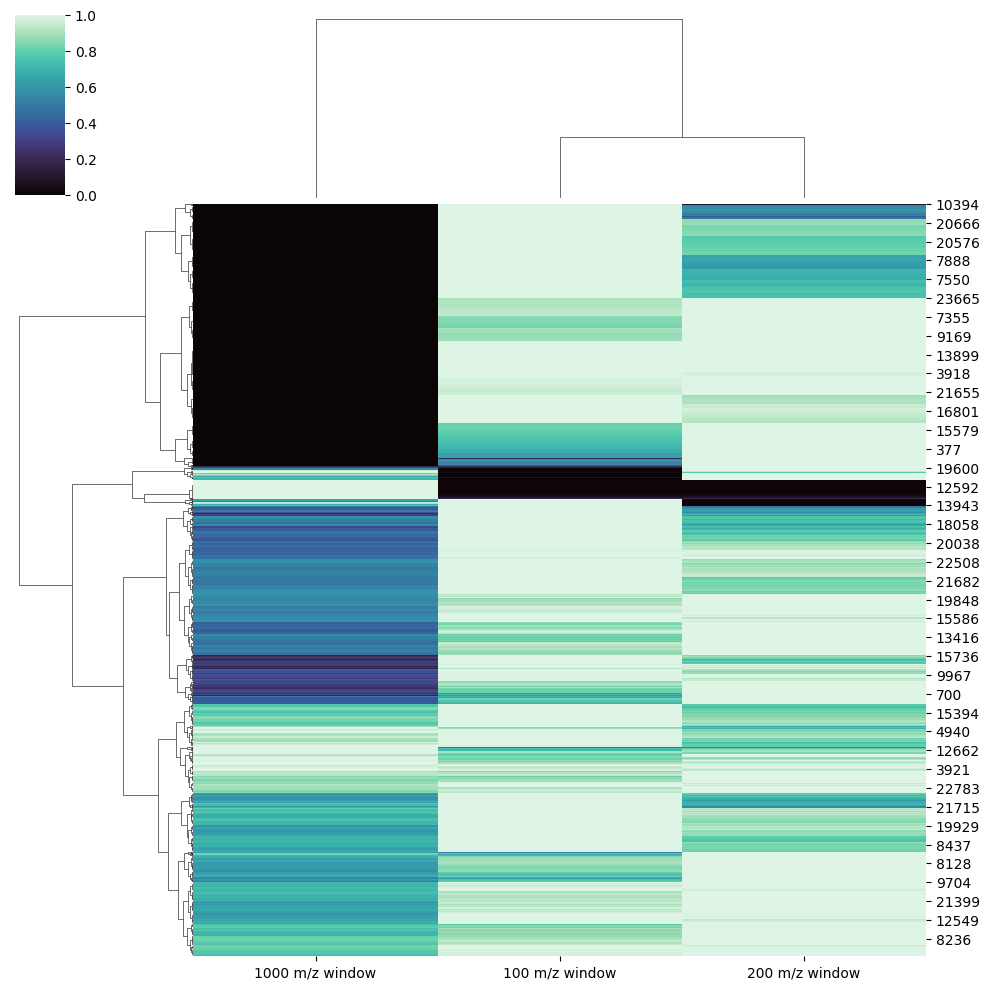

In [264]:
# make cluster plot 

from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize


#clustermethod='average'

dfa = dd[(~dd['file'].str.contains("qh2o"))]
dfa = dfa[(~dfa['file'].str.contains('blank'))]
clustermethod='ward'

cols = [mzw + ' m/z window' for mzw in dfa['Window Size (m/z)'].unique()]
abundances=dfa[cols].fillna(0)
df1=abundances.mean(axis=1)
df_std=abundances.std(axis=1)

p_list=[]
for ind in abundances.index:
    p=max(abs(abundances.loc[ind]-df1[ind]))/df_std[ind]
    if len(abundances.loc[ind][abundances.loc[ind]>1])<2:
        p=0
    p_list.append(p)

#abundances['p']=p_list
#abundances=abundances[abundances['p']>0.1]
#abundances=abundances.sort_values(by='p',ascending=False)
dfa['p']=p_list

#plt.hist(p_list,bins=100,range=[min(p_list),max(p_list)])

results_clustered=dfa[dfa['p']>0.1]
norm_abundances=results_clustered[cols].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)




cluster = AgglomerativeClustering( affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances)
print(cluster.n_clusters_)
print(cluster.n_leaves_)
print(cluster.labels_)
print(cluster.feature_names_in_)
results_clustered['cluster']=cluster.labels_

#results_clustered.fillna(0).to_csv(file_location+'clustered_results.csv')

clusterplot=norm_abundances
#clusterplot=clusterplot.drop(['p'],axis=1)
#clusterplot=clusterplot.transpose()

#clusterplot=clusterplot.sort_values(by='sort_order')
#clusterplot=clusterplot.drop(['sort_order'],axis=1)

# fig, ax = plt.subplots()


p1 = sns.clustermap(clusterplot,row_cluster=True,cmap='mako',method=clustermethod)

fig = plt.gcf()


plt.show()

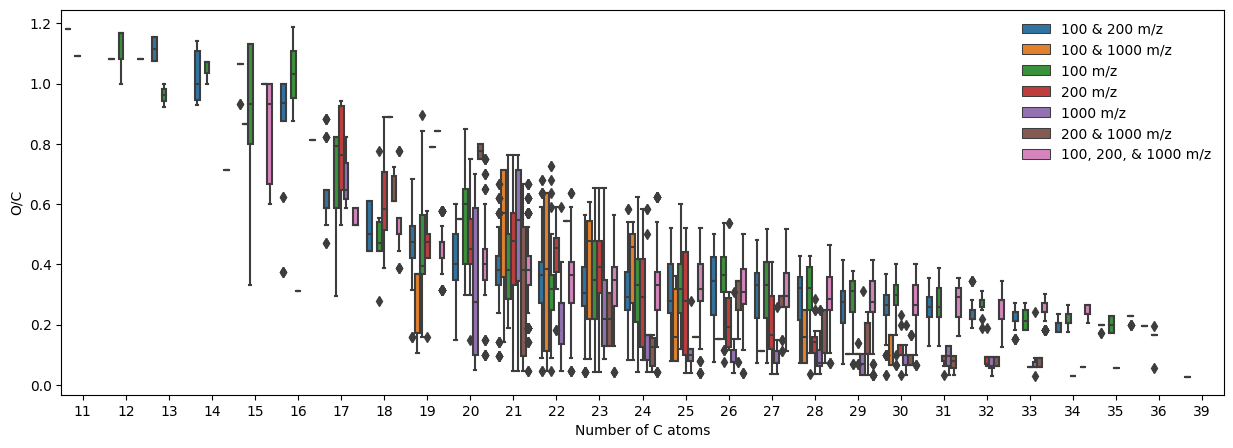

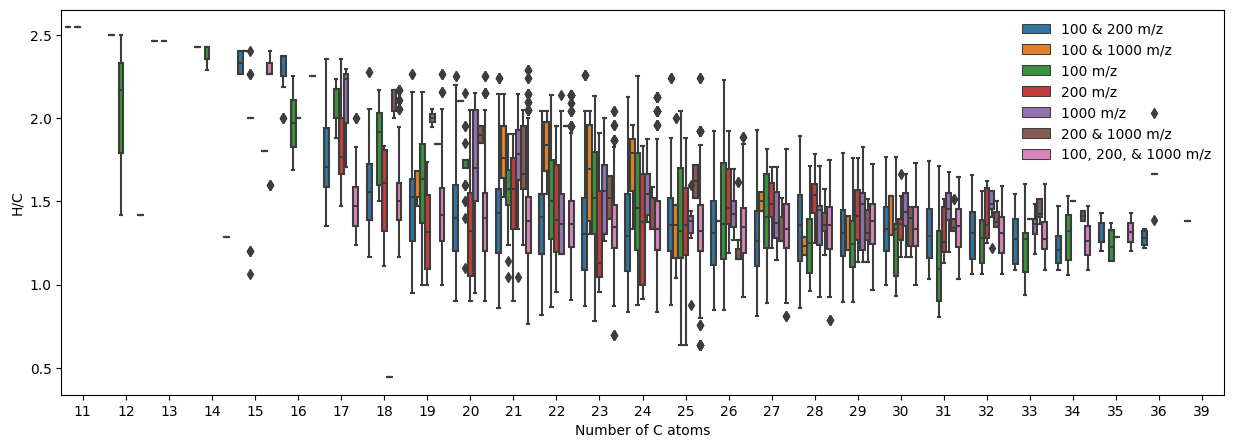

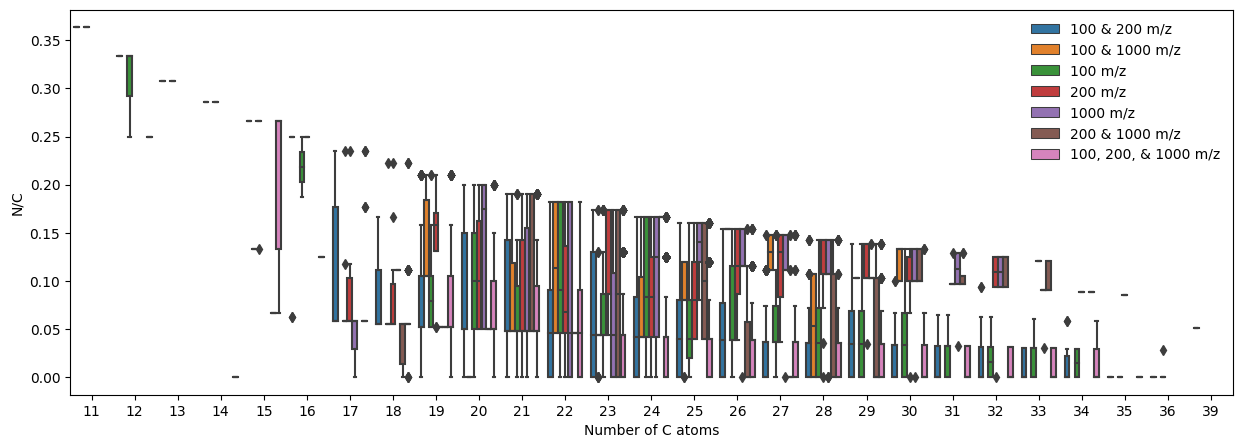

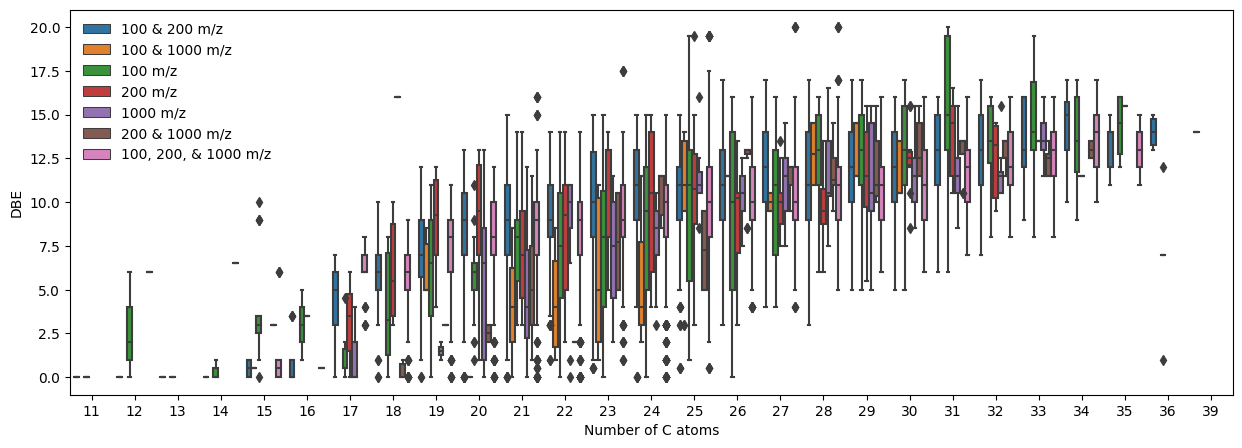

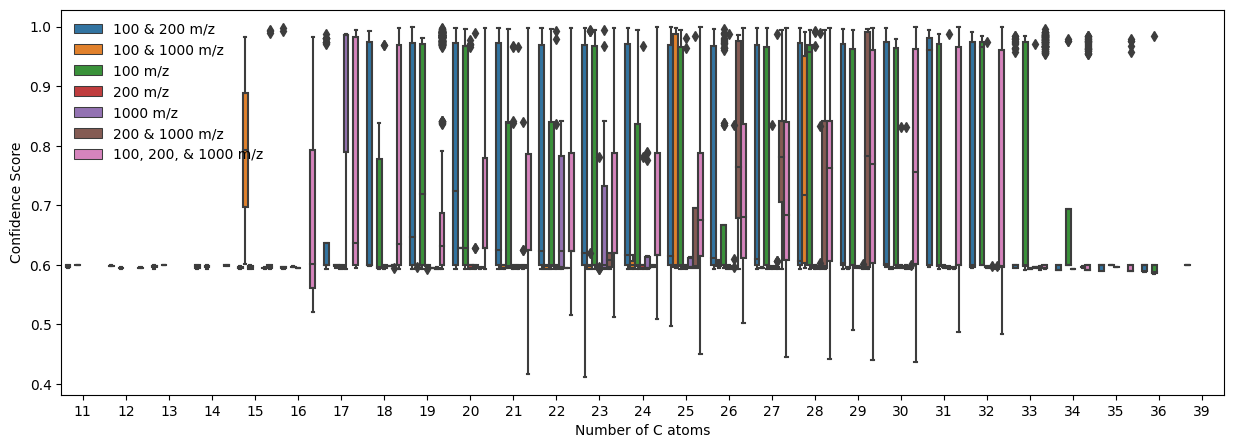

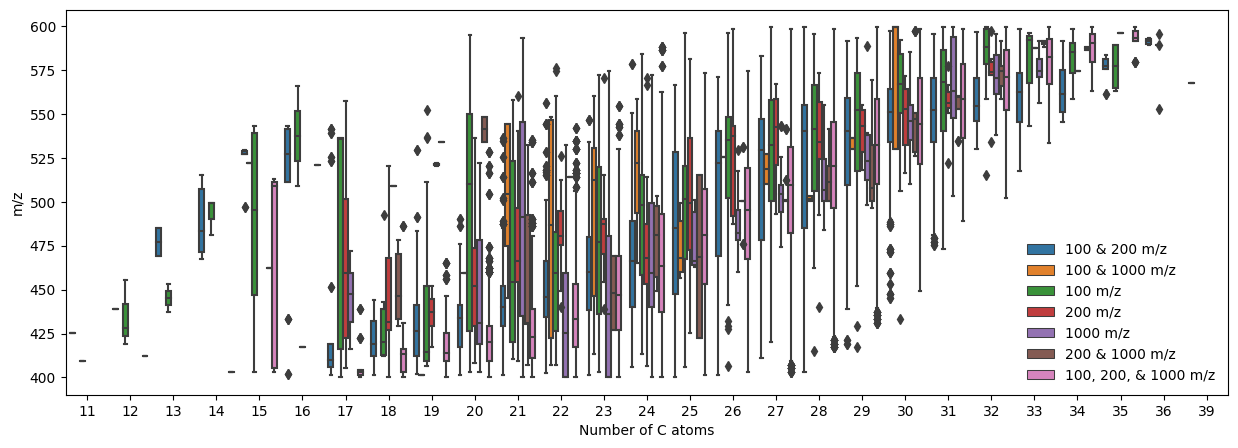

In [134]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)




fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'O/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'H/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()



fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'N/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'DBE', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()


fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'Confidence Score', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()


fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'm/z', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()



In [ ]:

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'm/z Error (ppm)', hue = 'FeatureIn',showfliers = True )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')

plt.show()

In [ ]:


column = 'N/C'  ## title for main plot
column2 = 'H/C'
hue_col = 'O'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))

mzfull = narrow_full
dffull = mzfull#[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
dffull.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'],legend=False, x=column, hue=hue_col, ax = ax1)
ax1.set_xlim(-0.1,0.3)
#ax1.set_title('Confidence scores for shared features m/z\nO/C range 0-20 (dark == 20 O)')


mz100 = narrow_only
df100 = mz100#[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
df100.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x=column, hue=hue_col, ax = ax2, legend = False)  # for some reason, order of mol class is reverse in narrow m/z range
ax2.set_xlim(-0.1,0.3)
#ax2.set_title('Confidence scores for narrow m/z\nO/C range 0-20 (dark == 20 O)')
"""
mzfull = narrow_full
dffull = mzfull#[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
dffull.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x=column2, legend = False, hue=hue_col, ax = ax2)
#ax1.set_xlim(-0.3,0.3)


mz100 = narrow_only
df100 = mz100#[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
df100.sort_values(by=['mol_class'],inplace=True)
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x=column2, hue=hue_col,linestyle = '--', ax = ax2, legend = False)  # for some reason, order of mol class is reverse in narrow m/z range

"""
#fig.suptitle(ttt, fontsize=14)
#fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [ ]:
# plot ms with cu features from both windows 

importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec



mz100_bs = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=400) & (mzfull_bs['Calibrated m/z']<=600)]
mzfull_cu= mzfull_bs_456[mzfull_bs_456['file'].str.contains('Slough_ENV')]

mz100_cu_t = mz100_bs[(mz100_bs['Calibrated m/z']>=400) & (mz100_bs['Calibrated m/z']<=600) ]
mz100_cu = mz100_cu_t[mz100_cu_t['file'].str.contains('Slough_ENV')]


In [ ]:
def getEICs(df):

    EICdic = {}
    
    for mz,cmz, mf,er,file in zip(df['m/z'],df['Calibrated m/z'],df['Molecular Formula'],df['m/z Error (ppm)'],df['file']):

        parser = data.master_data_holder[file]['parser']

        EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
        
        EICdic[mf]={'EIC_data':EIC[0][mz],'file':file, 'cal_mz':cmz,'ppm_err': er}

    return EICdic

In [ ]:
df = mz100_cu
df = df[(df['m/z']<=600)& (df['m/z']>=400)]
df = df[df['Fe']>0]
df = df[df['file'].str.contains('Slough_ENV') ]

narrowmz = getEICs(df)

df2 = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<=600)]
df2 = df2[df2['Fe']>0]
df2 = df2[df2['file'].str.contains('Slough_ENV') ]

fullmz = getEICs(df2)


In [ ]:
label = '100 m/z' #r'$\Delta$m/z 

label2 =  '1000 m/z'

from matplotlib.backends.backend_pdf import PdfPages

savefig = False

if savefig:
    pdf = PdfPages(dir+'/eics_Fe_slough_ppl_ALL.pdf')


for mf in narrowmz:   

    fig, ax = plt.subplots()
    
    eic = narrowmz[mf]['EIC_data']
    file = narrowmz[mf]['file']
    calmz = narrowmz[mf]['cal_mz']
    ppmerr = narrowmz[mf]['ppm_err']

    
    eict=eic.time
    eics=eic.eic

    inds = np.where(np.asarray(eict)<30)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=label)#
    
    move_down = False

    if mf in fullmz:

        eicf = fullmz[mf]['EIC_data']
        filef = fullmz[mf]['file']

        calmzf = narrowmz[mf]['cal_mz']
        ppmerrf = narrowmz[mf]['ppm_err']
        
        eictf=eicf.time
        eicsf=eicf.eic

        indsf = np.where(np.asarray(eictf)<30)

        eictf = np.asarray(eictf)[indsf]
        eicsf = np.asarray(eicsf)[indsf]

        ax.plot(eictf, eicsf, color = 'C0', label=label2)#
        ax.text(1.05, 0.32, 'm/z: %.5f \nerror (ppm): %.2f' %(calmzf, ppmerrf),
            color = 'C0',
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes,  fontsize = 8)
        
        move_down = True

    if move_down:
        ax.text(1.05, 0.4, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
            color = 'red',
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes,  fontsize = 8)

        move_down = False
    
    else:

        ax.text(1.05, 0.42, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
            color = 'red',
            horizontalalignment='left',
            verticalalignment='center',
            transform = ax.transAxes,  fontsize = 8)


    ax.set_xlim(0,30)
    ax.set_title(mf)
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left',frameon=False, borderaxespad=0,  prop={'size': 8})

    ax.set_xlabel('Time (min)')
    ax.set_ylabel("Intensity")
    sns.despine()
    fig.tight_layout()

    if savefig == False:
        plt.show()
    else:
        pdf.savefig()

if savefig:

    pdf.close()

In [ ]:
# invalids mfs for Cu
invalid_mf_cu = ['C15 H12 O15 N2 Fe1 Cu1', 
            'C26 H34 O8 Cu1',
            'C19 H38 O13 Cu1',
            'C30 H34 O2 13C1 Cu1',
            'C23 H36 O2 Fe1 Cu1',
            'C13 H12 O10 Fe1 Cu1',
            'C15 H15 O9 N1 Fe1 Cu1',
            'C27 H37 O1 N3 Fe1 Cu1',
            'C26 H48 O3 N2 Cu1',
            'C26 H35 O1 N1 Cu1']

# invalids mfs for Fe
invalid_mf = ['C15 H12 O15 N2 Fe1 Cu1', 
            'C27 H41 O7 N3 Fe1',
            'C23 H36 O2 Fe1 Cu1',
            'C19 H25 O6 N3 Fe1',
            'C23 H36 O2 Fe1 Cu1',
            'C13 H12 O10 Fe1 Cu1',
            'C15 H15 O9 N1 Fe1 Cu1',
            'C27 H37 O1 N3 Fe1 Cu1']

In [ ]:
label = '100 m/z' #r'$\Delta$m/z 

label2 =  '1000 m/z'

from matplotlib.backends.backend_pdf import PdfPages

invalid_mf = invalid_mf_cu
savefig = False

if savefig:
    pdf = PdfPages(dir+'/eics_Fe_slough_ppl_ALL.pdf')

for mf in narrowmz:   
    
    if mf not in invalid_mf:

        fig, ax = plt.subplots()
        
        eic = narrowmz[mf]['EIC_data']
        file = narrowmz[mf]['file']
        calmz = narrowmz[mf]['cal_mz']
        ppmerr = narrowmz[mf]['ppm_err']

        
        eict=eic.time
        eics=eic.eic

        inds = np.where(np.asarray(eict)<30)

        eict = np.asarray(eict)[inds]
        eics = np.asarray(eics)[inds]

        ax.plot(eict, eics,color = 'red', label=label)#
        
        move_down = False

        if mf in fullmz:

            eicf = fullmz[mf]['EIC_data']
            filef = fullmz[mf]['file']

            calmzf = narrowmz[mf]['cal_mz']
            ppmerrf = narrowmz[mf]['ppm_err']
            
            eictf=eicf.time
            eicsf=eicf.eic

            indsf = np.where(np.asarray(eictf)<30)

            eictf = np.asarray(eictf)[indsf]
            eicsf = np.asarray(eicsf)[indsf]

            ax.plot(eictf, eicsf, color = 'C0', label=label2)#
            ax.text(1.05, 0.32, 'm/z: %.5f \nerror (ppm): %.2f' %(calmzf, ppmerrf),
                color = 'C0',
                horizontalalignment='left',
                verticalalignment='center',
                transform = ax.transAxes,  fontsize = 8)
            
            move_down = True

        if move_down:
            ax.text(1.05, 0.4, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
                color = 'red',
                horizontalalignment='left',
                verticalalignment='center',
                transform = ax.transAxes,  fontsize = 8)

            move_down = False
        
        else:

            ax.text(1.05, 0.42, 'm/z: %.5f \nerror (ppm): %.2f' %(calmz, ppmerr),
                color = 'red',
                horizontalalignment='left',
                verticalalignment='center',
                transform = ax.transAxes,  fontsize = 8)


        ax.set_xlim(0,30)
        ax.set_title(mf)
        ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left',frameon=False, borderaxespad=0,  prop={'size': 8})

        ax.set_xlabel('Time (min)')
        ax.set_ylabel("Intensity")
        sns.despine()
        fig.tight_layout()

        if savefig == False:
            plt.show()
        else:
            pdf.savefig()

if savefig:

    pdf.close()

In [ ]:
# plot ms with cu features from both windows 

importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec

fig, ax2 = plt.subplots(figsize = (6.5,4))

#d1=lcmsfns.normMS(mz100_cu[mz100_cu['Cu']>0],mz100_cu[mz100_cu['Cu']>0])
d1=mz100_cu[mz100_cu['Fe']>0]

#d2=lcmsfns.normMS(mzfull_cu[mzfull_cu['Cu']>0],mzfull_cu[mzfull_cu['Cu']>0])
d2=mzfull_cu[mzfull_cu['Fe']>0]

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
df = mz100_cu
df = df[(df['m/z']<=600)& (df['m/z']>=400)]
df = df[df['Fe']>0]
df = df[df['file'].str.contains('Slough_ENV') ]
print(df['Molecular Formula'])
df = df[~df['Molecular Formula'].isin(invalid_mf_cu)]
print(df['Molecular Formula'])

print('full')
df2 = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<=600)]
df2 = df2[df2['Fe']>0]
df2 = df2[df2['file'].str.contains('Slough_ENV') ]
print(np.shape(df),  np.shape(df2))
print(df2['Molecular Formula'])
df2 = df2[~df2['Molecular Formula'].isin(invalid_mf_cu)]
print(df2['Molecular Formula'])


print('over')

for i in invalid_mf_cu:
    print(i)

ax2 = lcmsfns.plot_ms(df1=df,  df2=df2, start_mz=400, end_mz=600,ax_ms=ax2, norm=False)

sns.despine(ax=ax2)

ax2.set_xlim(400,600)
ax2.set_ylim(bottom=0)

ax2.set_title('Cu Features in Slough-ENV')
ax2.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

In [ ]:
# 100 m/z window, error plots with blank substraction

importlib.reload(icrms)
importlib.reload(lcmsfns)
df = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
print(np.shape(unique_100mz))
print(np.shape(df))
fig = lcmsfns.plotUnique(df,ps=10)

fig.suptitle('100 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()



In [ ]:
# full m/z window, error plots with blanks removed 

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]
df = lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6)
print(np.shape(unique_fullmz_456))
print(np.shape(df))

fig = lcmsfns.plotUnique(df,ps=10)
fig.suptitle('1000 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()

In [ ]:

mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]
df = mz100_bs
print(df)

df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()
